## Imports and setup

In [40]:
import os
import json
from collections import defaultdict
import pprint

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
#load data into a runs dict and calculate best run
def load_runs(runs_dir):
    runs = []
    best_run = None
    for run_id in os.listdir(runs_dir):
        run_dir = os.path.join(runs_dir, run_id)
        try:
            run = {"id": run_id}
            with open(os.path.join(run_dir, "history.json"), "r") as f:
                run["history"] = json.loads(f.read())
            with open(os.path.join(run_dir, "params.json"), "r") as f:
                run["params"] = json.loads(f.read())

            run["last_val_iou"] = run["history"]["val_iou"][-1]

            runs.append(run)
            #determine best run
            if best_run is None or run["last_val_iou"] > best_run["last_val_iou"]:
#                 print("new best run", run["id"])
                best_run = run

        except:
            print("error loading a run... maybe it's still in progress?")
            
    return runs, best_run

In [42]:
def aggregate_iou_by_param_val(runs, reducer=np.mean):
    ious_by_param_value = defaultdict(lambda: defaultdict(list))

    for run in runs:
        #append last validation iou to each param value for this run
        params = run["params"]
        for param, val in params.items():
            ious_by_param_value[param][val].append(run["last_val_iou"])

    # pprint.pprint(ious_by_param_value)

    #calculate average (or whatever reducer is passed)
    ious_by_param_value = {
        param: {
            val: reducer(ious) for val, ious in val_ious.items()
        } for param, val_ious in ious_by_param_value.items()
    }
    
    return ious_by_param_value

In [178]:
#plot average ious by parameter value
def plot_param_ious(ious_by_param_value, exclude_params=[], rotate_labels=False):
    ious_by_param_value = {k: v for k, v in ious_by_param_value.items() if k not in exclude_params}
    plt.figure(figsize=(1.5 * len(ious_by_param_value), 3))

    ax = None
    for i, (param, val_ious) in enumerate(ious_by_param_value.items()):
        if i == 0:
            ax = plt.subplot(1, len(ious_by_param_value), i+1)
        else:
            _ax = plt.subplot(1, len(ious_by_param_value), i+1, sharey=ax)
            plt.setp(_ax.get_yticklabels(), visible=False)

        vals, ious = zip(
            *sorted([(val, iou) for val, iou in val_ious.items()], key=lambda x: x[0])
        )
        #map values to strings and ensure both are lists...
        vals = [str(val) for val in vals]
        ious = [i for i in ious]

        sns.barplot(x=vals, y=ious)
#         plt.title(f"Average Validation IoU for {param}")
        plt.xlabel(param)
        if rotate_labels:
            plt.xticks(rotation=90)
        if i == 0:
            plt.ylabel("IoU")

    plt.tight_layout()
    plt.show()

In [296]:
def graph_metric(train, val, title, metric_name, xlabel=True):
    plt.plot(train, label=f'train_{metric_name}', linestyle="--")
    plt.plot(val, label=f'val_{metric_name}')
#     plt.title(title)
    if xlabel:
        plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()

def graph_metrics(
    history,
    metric_names=[
#         "loss",
#         "accuracy",
        "f1", #f1 and iou seem very similar
#         "iou"
    ],
    metric_titles=[
#         "Training and Validation Loss",
#         "Training and Validation Accuracy",
        "Training and Validation F1 Score",
#         "Training and Validation IoU"
    ]
):
    plt.figure(figsize=(4, 3 * len(metric_names)))
    
    ax = None
    for i, (metric, title) in enumerate(zip(metric_names, metric_titles)):
        if i == 0:
            ax = plt.subplot(len(metric_names), 1, i+1)
            _ax = ax
        else:
            _ax = plt.subplot(len(metric_names), 1, i+1, sharex=ax)
        if i != len(metric_names) - 1:
            plt.setp(_ax.get_xticklabels(), visible=False)
        
        xlabel = i == len(metric_names) - 1
        graph_metric(history[metric], history[f"val_{metric}"], title, metric, xlabel=xlabel)

    plt.tight_layout()
    plt.show()

In [297]:
custom_cnn_runs, custom_cnn_best_run = load_runs("./runs/custom")

In [298]:
print("best custom run id:", custom_cnn_best_run["id"])
pprint.pprint(custom_cnn_best_run["params"])
print("iou:", custom_cnn_best_run["last_val_iou"])

best custom run id: b23ed024-fcda-483b-9877-03e3baff621c
{'augmentation': False,
 'batch_size': 128,
 'conv_blocks': 4,
 'learning_rate': 0.001,
 'regularization': False}
iou: 0.07507561892271042


In [299]:
custom_cnn_ious_by_param_value = aggregate_iou_by_param_val(custom_cnn_runs)
pprint.pprint(custom_cnn_ious_by_param_value)

{'augmentation': {False: 0.0490231970557943, True: 0.04963111335580999},
 'batch_size': {32: 0.058072278276085854,
                64: 0.04467810760252178,
                128: 0.04525065726528947},
 'conv_blocks': {3: 0.047276154841081455,
                 4: 0.04434161549434066,
                 5: 0.0585500025190413},
 'learning_rate': {1e-05: 0.05162286792289127,
                   0.0001: 0.05227853655815125,
                   0.001: 0.043576927529647945},
 'regularization': {False: 0.05770260865489642, True: 0.04130419113789685}}


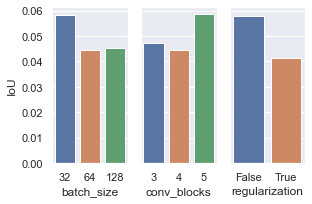

In [300]:
plot_param_ious(custom_cnn_ious_by_param_value, exclude_params=["learning_rate", "augmentation"])

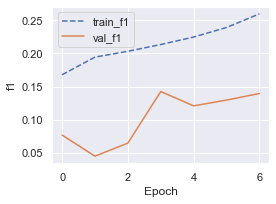

In [301]:
# for run in runs:
#     pprint.pprint(run["params"])
#     graph_metrics(run["history"])
graph_metrics(custom_cnn_best_run["history"])

## Resnet data

In [302]:
resnet_runs, resnet_best_run = load_runs("./runs/resnet")

In [303]:
print("best resnet run id:", resnet_best_run["id"])
pprint.pprint(resnet_best_run["params"])
print("iou:", resnet_best_run["last_val_iou"])

best resnet run id: cef58318-a912-46ca-9970-4cc1da7ca1e0
{'augmentation': False,
 'batch_size': 512,
 'input_dropout': 0,
 'learning_rate': 0.001}
iou: 0.10596543550491333


In [304]:
resnet_ious_by_param_value = aggregate_iou_by_param_val(resnet_runs)
pprint.pprint(resnet_ious_by_param_value)

{'augmentation': {False: 0.07972797405506883, True: 0.07899992563761771},
 'batch_size': {32: 0.08425163394874996,
                128: 0.07718705213986911,
                512: 0.07731175795197487},
 'input_dropout': {0: 0.08953921327536757,
                   0.3: 0.0812805907593833,
                   0.7: 0.06637337841093541},
 'learning_rate': {1e-05: 0.059547293931245804,
                   0.0001: 0.08212061692029238,
                   0.001: 0.08890108967369253}}


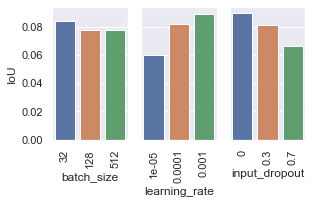

In [305]:
plot_param_ious(resnet_ious_by_param_value, exclude_params=["augmentation"], rotate_labels=True)

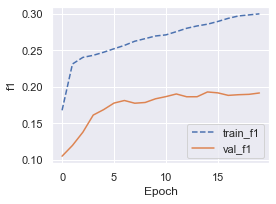

In [306]:
# for run in runs:
#     pprint.pprint(run["params"])
#     graph_metrics(run["history"])
graph_metrics(resnet_best_run["history"])